# Customer Churn Prediction
### What is customer churn?
Customer churn is one of the most important metrics for a growing business to evaluate. While it's not the happiest measure, it's a number that can give your company the hard truth about its customer retention. Customer churn is the percentage of customers that stopped using your company's product or service during a certain time frame. To learn more about it, visit this<a href="https://www.investopedia.com/terms/c/churnrate.asp" target="_blank"> link.</a>
<img src="pi.png" alt="Alternative text" />
## Project Scope
In this project, the dataset I will be analysing contains information about customers of a bank. I will initially do an EDA (Exploratory Data Analysis) to visualize and and extract key information that influences customers to churn. Then I will try to use Machine Learning models to try and predict whether a customer will churn or not. 
This is a **classification problem**, and for evaluating the models and optising them, the performance metric I will be using is **Recall**. I have chosen to do so, since its more important for banks to correctly identify the positive class (true churn).

*Skills demonstrated: Exploratory Data Analysis, Visualisation, Data Preprocessing (Feature Selection, Feature Encoding, Feature Scaling), Dealing with Class Imbalance using SMOTE, and Model Tuning.* <br>
*ML models used:  Logistic Regression, Support Vector Machines, Random Forests, Gradient Boosting, and XGBoost.*

### Importing the relevant libraries

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# statistical libs
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

### We import the data and take a quick look at it

In [147]:
df = pd.read_csv("churn_data.csv")
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


>Target variable is **"Exited"**, where 1 denotes that a customer has churned and 0 meaning that they have not churned. Also, we see that we can remove 'RowNumber', 'CustomerId', and 'Surname' as they are specific to each customer.

In [148]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


> Our dataset has no missing values! Good for us. Next, I will check the summary statistics for this dataset. 

In [150]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


Some important observations here: <br>
* The age of customers ranges from 18 to 92, with a mean of approximately equal to 39.
* The mean (and median) tenure is 5 years, so the majority of customers is loyal.
* About 50% of the customers are active.
    
Next, I will create train and test sets, and use them later on to evaluate our Machine Learning models. Doing this now can save our models from statistical bias and ensure that model evaluation will be performed on unseen data.


### Creating train and test sets

scikit-learn's train_test_split() function, implements random sampling. Our dataset is quite large, in terms of observations vs number of features it is also okay, as such, we do not risk introducing sampling bias.

*  Random sampling is a part of the sampling technique in which each sample has an equal probability of being chosen
* sampling bias is a bias in which a sample is collected in such a way that some members of the intended population have a lower or higher sampling probability than others.

In [151]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {}'.format(train_df.shape))
print('Test set: {}'.format(test_df.shape))

Train set: (8000, 11)
Test set: (2000, 11)


### Exploratory Data Analyisis (EDA)
* Target Variable: Exited 
* The target variable can take on two values: (0) no churn and (1) for churn

Text(0.5, 1.0, 'Retained vs Churned Count Plot')

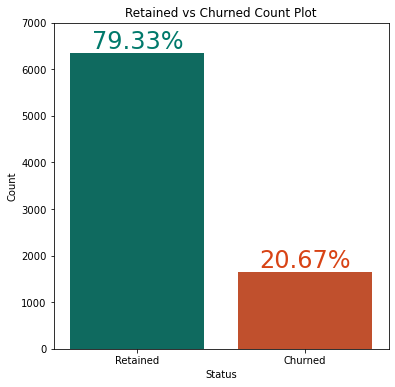

In [152]:
font_size = 20
colors = ['#00796B', '#D84315']
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label, xy=(index, value + 250), ha='center', va='center', color=colors[index], size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000])
plt.title("Retained vs Churned Count Plot")

We can see that the bank has kept almost 80% of its customers. Its important to note here that the data is highly **imbalanced/skewed** since the difference between retained and churned is very high, and as such accuracy might not be a very good metric for model evaluation. <br> Next, we separate the **categorical features** from the **continuous** ones.

In [153]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous:', continuous)
print('Categorical: ', categorical)

Continuous: ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
Categorical:  ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


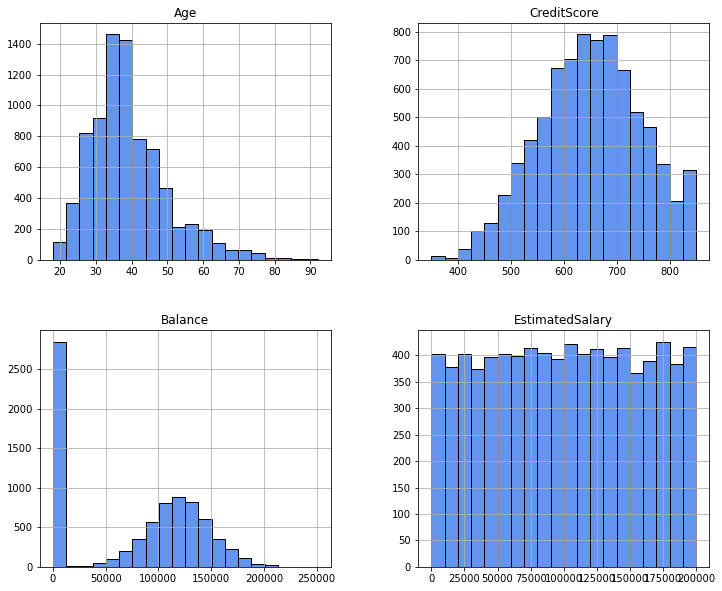

In [154]:
train_df[continuous].hist(figsize=(12, 10), bins=20, layout=(2, 2), color='cornflowerblue',edgecolor='black', linewidth=1);

Some observations here:
* 'Age' is slightly heavy tailed, as it extends more further to the right of the median than to the left.
* Most values for 'CreditScore' are above 600.
* 'Balance' follows a fairly normal distribution, ignoring the first bin.
* Can't decypher important information from the distribution of 'EstimatedSalary'.

<AxesSubplot:>

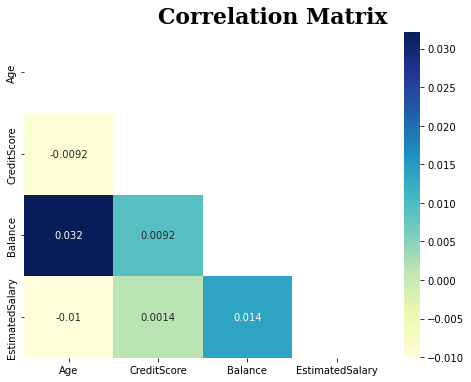

In [155]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
color_palette = ["#5833ff","#da8829"]
mask = np.triu(np.ones_like(train_df[continuous].corr())) # trim upper part of diag from df_corr
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
sns.heatmap(train_df[continuous].corr(),mask=mask,annot=True,cmap='YlGnBu')

> No significant correlation can be observed here, so no multicolliearity issues here. Next we will take a look at the features in depth.

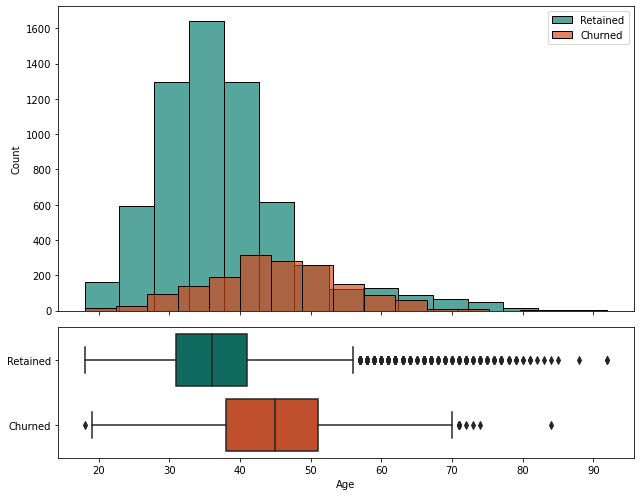

In [156]:
# helper func
def plot_continuous(feature):
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 7), sharex=True, gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df, x=feature, bins=15, color=color, alpha=0.66, edgecolor='black', label=label, kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])
    plt.tight_layout()
    
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

> We can see that theres an evident difference between age groups, as older customers are more likely to churn. This observation could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

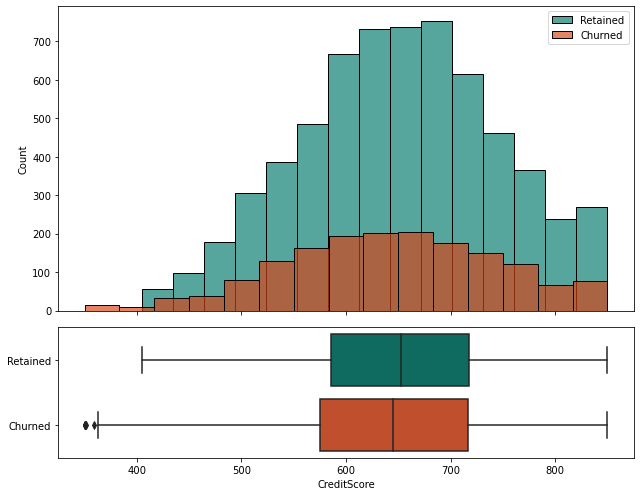

In [157]:
plot_continuous('CreditScore')

>We see that no significant difference in churned and retained customers in terms of credit scores. 

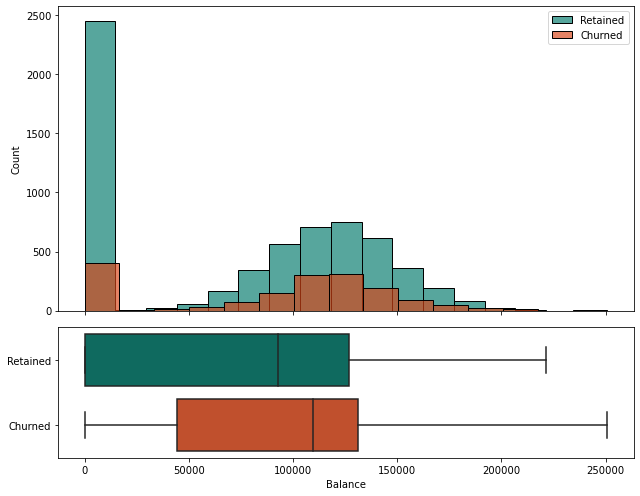

In [158]:
plot_continuous('Balance')

>It is interesting that many of the accounts that have not churned have low account balance.

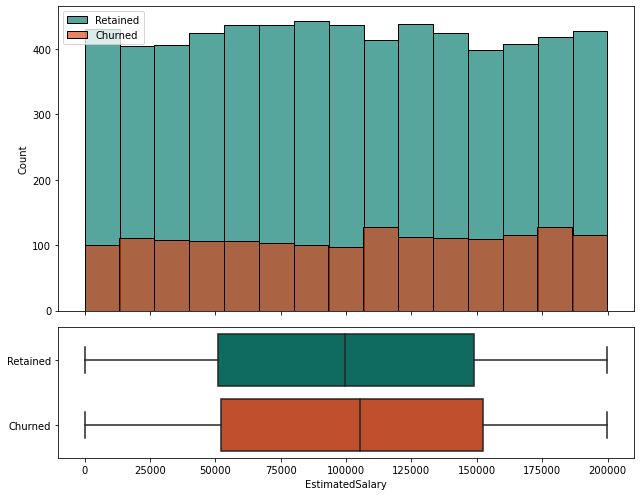

In [159]:
plot_continuous('EstimatedSalary')

>Salary doesn't have a significant effect on the likelihood to churn, as we see similar uniform distributions here.

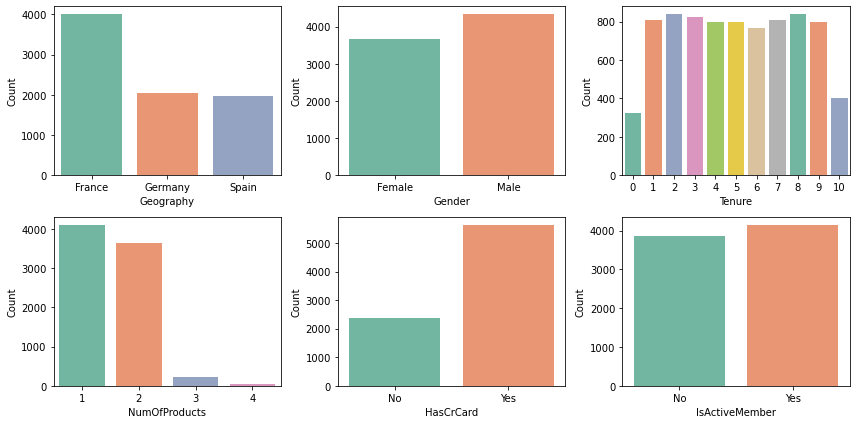

In [160]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
df_cat = train_df[categorical]

for index, column in enumerate(df_cat.columns):
    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df,palette="Set2")
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()

Some important observations here:
* The bank has customers in three countries (France, Spain, and Germany) with most customers being in France.
* Male customers are more than female customers.
* Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is quite similar.
* Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4.
* A significant majority of customers has a credit card.
* Almost 50% of customers are not active.

Again, we will look at these features in greater detail.

In [161]:
# helper func
def plot_categorical(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x=feature, hue='Exited', data=train_df, palette=colors, ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature, y='Exited', data=train_df, ax=ax2,palette="Set2")
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])
    plt.tight_layout()

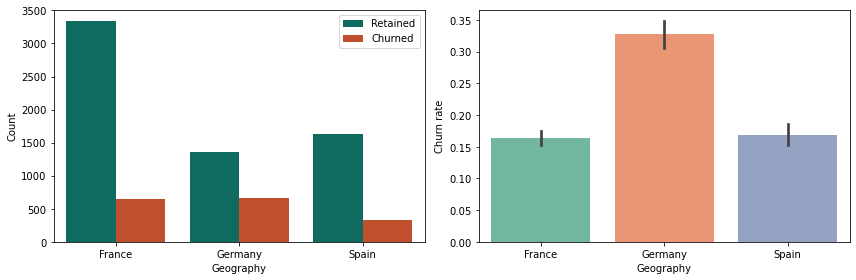

In [162]:
plot_categorical('Geography')

>Customers in **Germany** are more likely to churn than customers in the other two countries. This could be due to higher competition or different preferences for German customers or other reasons that needs to be investigated.

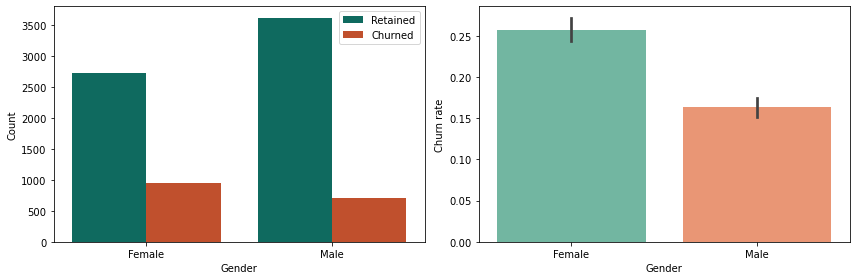

In [163]:
plot_categorical('Gender')

>Female customers are more likely to churn.

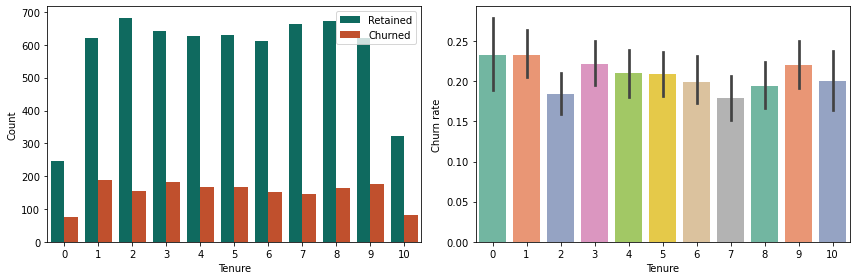

In [164]:
plot_categorical('Tenure')

>Tenure does not seem to affect the churn rate.

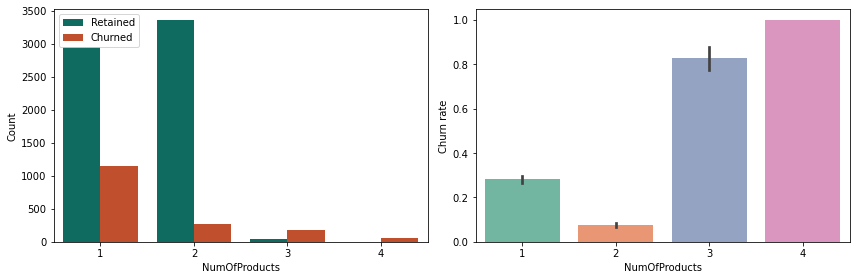

In [165]:
plot_categorical('NumOfProducts')

>Buying more products leads to more churn?! To explain this, some solid domain research would help.

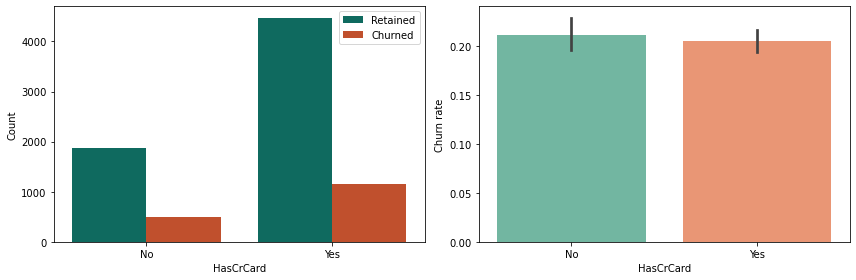

In [166]:
plot_categorical('HasCrCard')

>Having a credit card does not affect the churn rate.

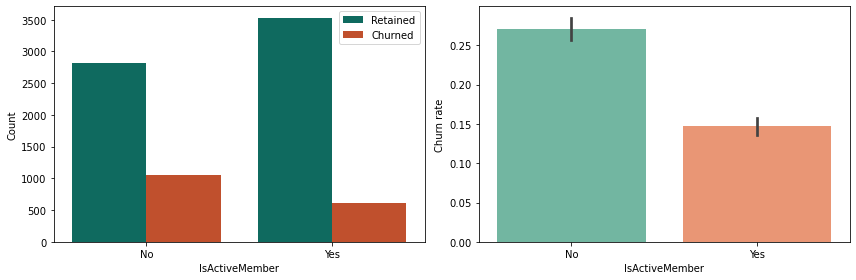

In [167]:
plot_categorical('IsActiveMember')

>Inactive members are more likely to churn! So the bank could actually take initiatives to actively engage the inactive customers and or create/ adjust policies to faciliate the inactive customers to become active and in turn, achieve their retention. 

### Data Preprocessing
Data Processing is the task of converting data from a given form to a much more usable and desired form i.e. making it more meaningful and informative.
#### Feature Selection
* 'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
* The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant.
* This can be confirmed from a chi-square test.

In [168]:
chi2_array, p_array = [], []
for column in categorical:
    ct = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(ct)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array })
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,1210.083322,4.758297e-262
0,Geography,247.962789,1.430753e-54
5,IsActiveMember,187.529547,1.100514e-42
1,Gender,107.027897,4.389468e-25
2,Tenure,14.590987,1.477004e-01
4,HasCrCard,0.449314,5.026607e-01


>'Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05, confirming our initial hypothesis that these two features are not of much importance and can be discarded.

In [169]:
to_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(to_drop, axis=1)

#### Encoding Categorical Features
Our dataset contains two features that require encoding: **Gender** and **Geography**.

In [170]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])
train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0 })

#### Feature Scaling 
Will use StandardScaler(), which standardises features by subtracting the mean and dividing by the standard deviation. This results in features with zero mean and unit variance.

In [171]:
scaler = StandardScaler()
scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

In [172]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

### Addressing Class Imbalance
Why is this important? 
* Most machine learning algorithms assume data equally distributed. So when we have a class imbalance, the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class.

I will be using the SMOTE ('Synthetic Minority Oversampling Technique') algorithm to deal with this issue. 
* SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.
To read more on this algorithm, refer to this <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/" target="_blank"> link.</a>

In [173]:
y_train.value_counts()

0    6346
1    1654
Name: Exited, dtype: int64

In [174]:
over = SMOTE(sampling_strategy='auto', random_state=2)
X_train, y_train = over.fit_resample(X_train, y_train)
y_train.value_counts()

0    6346
1    6346
Name: Exited, dtype: int64

### Machine Learning
We start off by using two baseline models (Naive Bayes and Logistic Regression). Why is this a good practice?
* The baseline models are references for our trained ML models. With baseline models, we try to explain how our trained model is good and the score of the baseline model is considered the threshold.

In [175]:
# defining the scoring metric beforehand
scoring_metric = 'recall'

comparison_dict, comparison_test_dict = {}, {}
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=2))]

cv_base_mean, cv_std = [], []
for clf in clf_list:
    cv = cross_val_score(estimator=clf[1], X=X_train, y=y_train, scoring=scoring_metric, cv=5, n_jobs=-1)
    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall): ')
for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.7
   Logistic Regression: 0.7


In [182]:
# Creating some helper functions for use later
def clf_performance(classifier, classifier_name, classifier_name_abv):
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_, X=X_train, y=y_train, cv=5, 
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()
    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)
    plt.tight_layout()

def plot_conf_mx(cm, ax):
    sns.heatmap(data=cm, annot=True, cmap='YlOrBr', annot_kws={'fontsize': 30}, ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);
    
def plot_learning_curve(estimator, X, y, ax, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='darkorange')

    ax.plot(train_sizes, train_scores_mean, color='dodgerblue', marker='o', linestyle='-', label='Training Score')
    ax.plot(train_sizes, test_scores_mean, color='darkorange', marker='o', linestyle='-',label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14)

Now to actually start building models. I will also perform *hyperparameter optimization* and make plots of *learning curves* for each classifier. 
* In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process.
* A learning curve usually refers to a plot of the prediction accuracy/error vs. the training set size (i.e: how better does the model get at predicting the target as you the increase number of instances used to train it).

The classifiers I will be using:
1. Logistic Regression 
2. Support Vector Classifier 
3. Random Forest Classifier 
4. Gradient Boosting Classifier 
5. Xtreme Gradient Boosting Classifier 

#### Logistic Regression


 Logistic Regression
-------------------------------
   Best Score (recall): 0.728
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


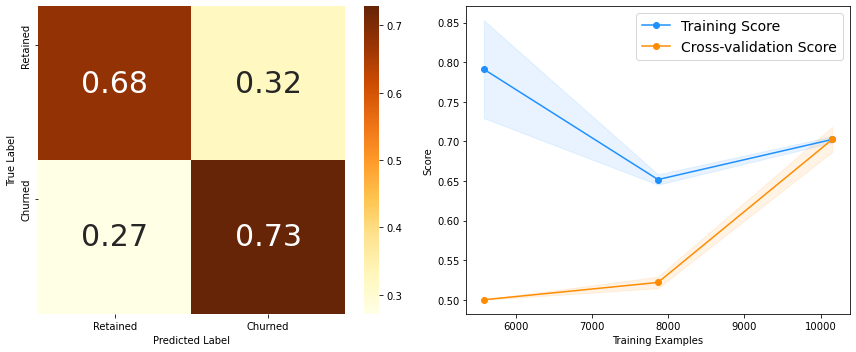

In [183]:
lr = LogisticRegression(random_state=2)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'] }

lr_clf = GridSearchCV(estimator=lr, param_grid=param_grid, scoring=scoring_metric, cv=5, verbose=False, n_jobs=-1)
best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

#### Support Vector Classifier


 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.782
   Best Parameters: 
      C: 2
      gamma: scale
      kernel: rbf


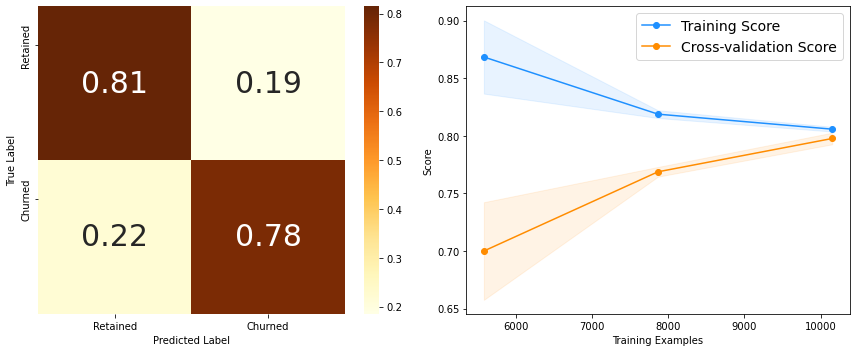

In [184]:
svc = SVC(probability=True, random_state=2)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]} ]

svc_clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring_metric, cv=5, verbose=False, n_jobs=-1)
best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

#### Random Forest Classifier


 Random Forest
-------------------------------
   Best Score (recall): 0.775
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


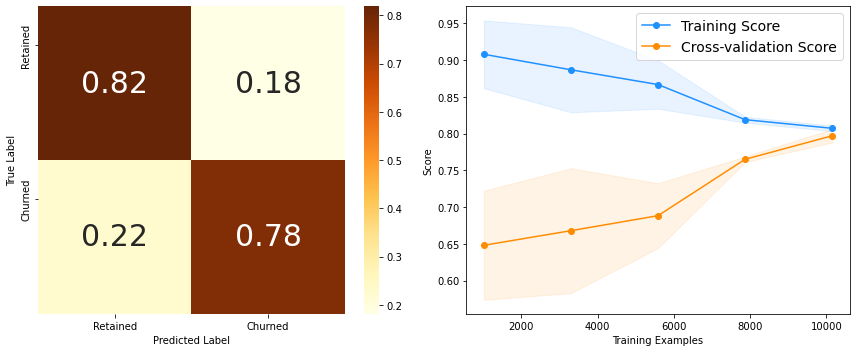

In [185]:
rf = RandomForestClassifier(random_state=2)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring_metric, cv=5, verbose=False, n_jobs=-1)
best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

#### Gradient Boosting Classifier


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.762
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.75
      tol: 0.01
      validation_fraction: 0.2


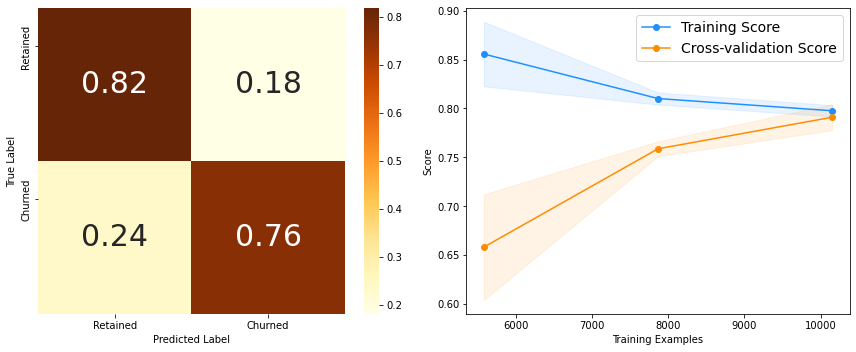

In [186]:
gbc = GradientBoostingClassifier(random_state=2)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring=scoring_metric, cv=5, verbose=False, n_jobs=-1)
best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

In [187]:
best_gbc_clf.best_estimator_.n_estimators_

300

#### XGBoost


 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.772
   Best Parameters: 
      colsample_bytree: 0.75
      gamma: 0.5
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75


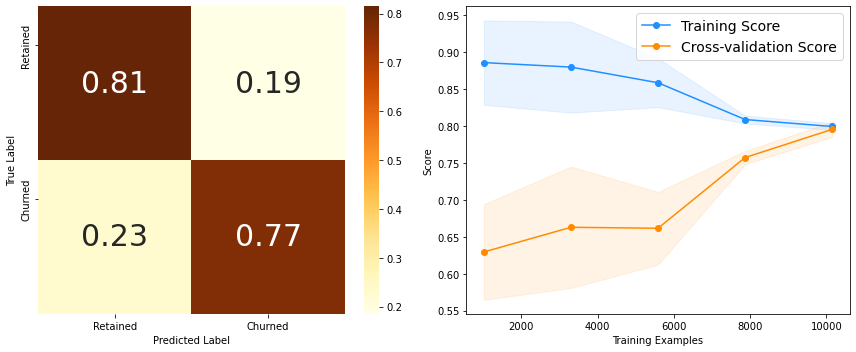

In [188]:
xgb = XGBClassifier(random_state=2)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scoring_metric, cv=5, verbose=False, n_jobs=-1)
best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

### Ensemble Learning experiment
#### We can combine the predictions of all these classifiers above to determine if we get better predictive performance compared to each individual classifier. This practice is the main motivation behind Ensemble Learning.
Specifically, I will use **Soft Voting**. In this case, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote and is accepted.
* In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.
* Soft voting entails combining the probabilities of each prediction in each model and picking the prediction with the highest total probability.

Soft Voting
-----------------
  Recall:  0.777


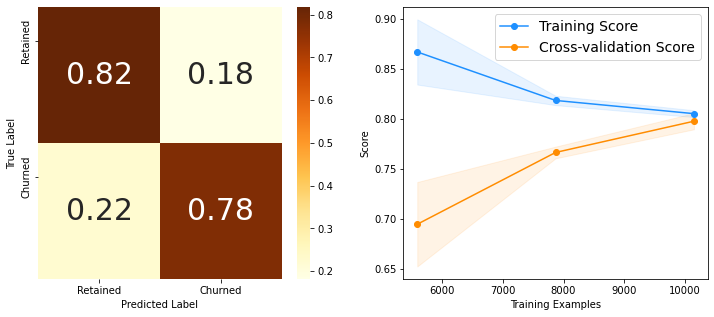

In [189]:
estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:], voting='soft', n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

### Results Interpretation 
In terms of learning curves, for all models, there is a tiny gap between the two curves at the end of training. This observation indicates that we do not overfit the training set.

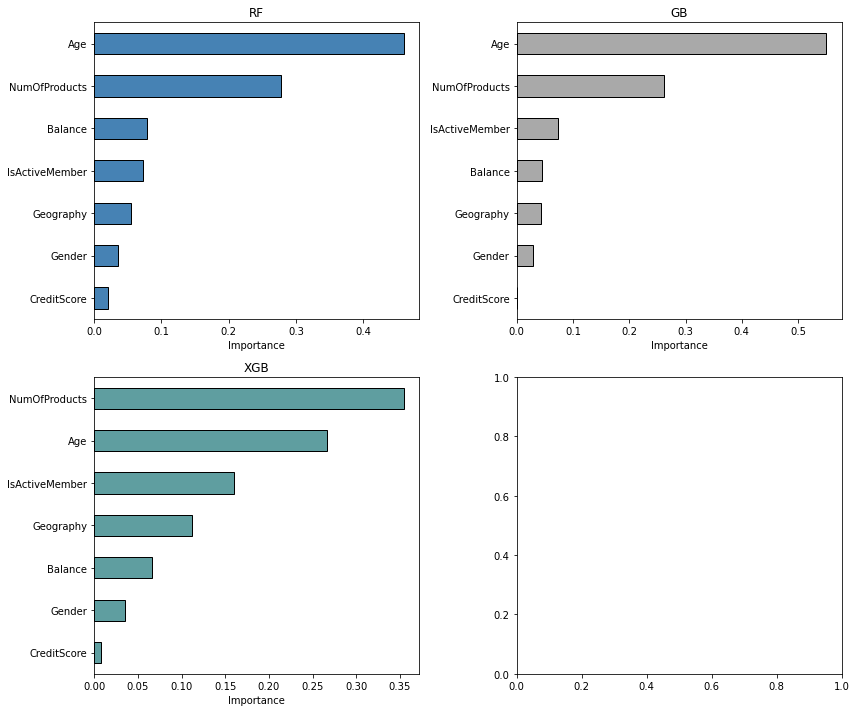

In [190]:
# Feature Importances
def plot_feature_imp(classifier, classifier_name, color, ax):
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color, edgecolor='black', legend=False, ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']
fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB'], [best_rf_clf, best_gbc_clf, best_xgb_clf])):
    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')
plt.tight_layout()

>**'Age'** and **'NumOfProducts'** seems like the most useful features for all classifiers, followed by 'IsActiveMember' and 'Balance'. On the other hand, *'CreditScore' is the least important feature* with a small value close to zero for all estimators.

### Performance Comparison
Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall, and area under the ROC curve or simply AUC):
To begin with, we can compare the performances of our classifiers using the four metrics:
* Accuracy
* Precision
* Recall
* AUC-ROC curve

In [191]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix, index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall,AUC
LR,0.702332,0.692388,0.728175,0.738207
SVC,0.797825,0.808320,0.780807,0.878208
RF,0.797116,0.810575,0.775449,0.882108
GBC,0.790262,0.807718,0.761897,0.874644
XGB,0.793334,0.806521,0.771825,0.874433
SVot,0.797353,0.809954,0.777025,0.884580


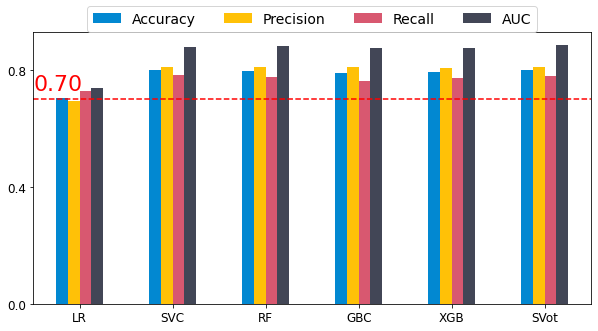

In [197]:
comparison_df.plot(kind='bar', figsize=(10, 5), fontsize=12, color=['#0288D1', '#FFC107', '#D85870', '#424656'])

plt.legend(loc='upper center', fontsize=font_size - 6, ncol=len(comparison_df.columns), bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

Using single metrics is not the only way of comparing the predictive performance of classification models. The ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classifier at different classification thresholds. It plots the true positive rate (recall) against the false positive rate.

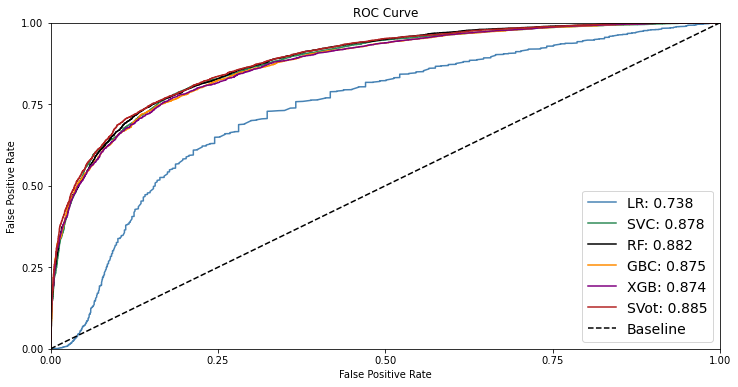

In [198]:
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']
fig, ax = plt.subplots(figsize=(12, 6))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr, tpr, color=colors_comp[index], label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14)

> The dashed diagonal line represents a **purely random classifier**. A good classifier stays as far away from that line as possible (toward the top-left corner).

The cumulative gain curve evaluates the performance of the model by comparing the results of a random pick with the model. The graph shows the percentage of targets reached while considering a certain percentage of the population with the highest probability to be target according to the model. The scikitplot library offers an easy way of plotting this chart:

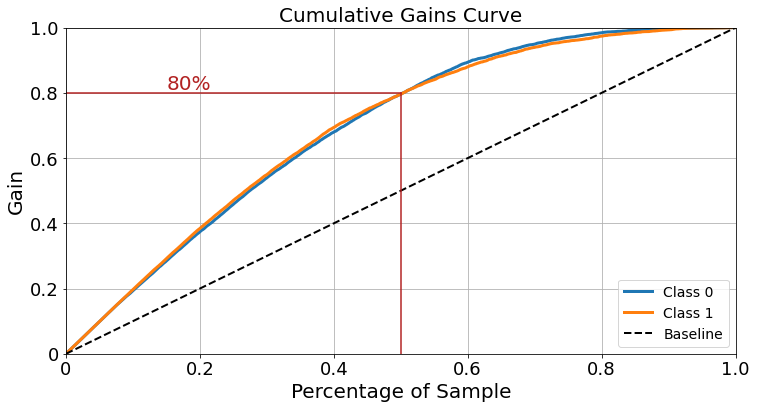

In [199]:
y_pred = cross_val_predict(tuned_voting_soft, X_train, y_train, cv=5, method='predict_proba')

fig, ax = plt.subplots(figsize=(12, 6))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14)

>This chart shows that if we target 50% of the customers most likely to churn (according to the model), the model will pick 80% of customers who will actually churn, while the random pick would pick only 50% of the targets.

## Evaluating the model on Test Data
We now want to see how our model does on unseen data. Before however, we apply the same data preprocessing on the test data.

In [200]:
test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

In [202]:
# helper test func
def test_func(classifier, classifier_name, ax):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]
    
    sns.heatmap(cm, annot=True, annot_kws={'fontsize': 24}, cmap='YlOrBr', ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);

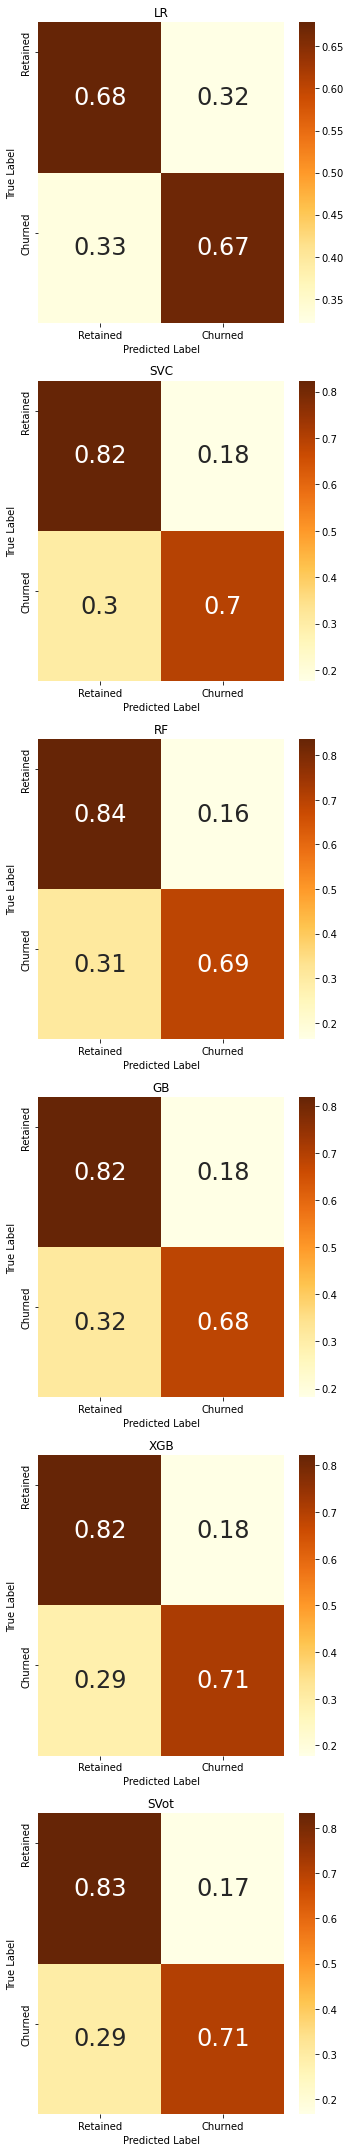

In [203]:
tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(6, 1, figsize=(5, 30))
for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'SVot'], 
                                    [best_lr_clf.best_estimator_, best_svc_clf.best_estimator_, 
                                     best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, 
                                     best_xgb_clf.best_estimator_, 
                                     tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])
plt.tight_layout()

In [204]:
comparison_test_df = pd.DataFrame(comparison_test_dict, index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall
LR,0.677000,0.330759,0.671018
SVC,0.799500,0.483696,0.697128
RF,0.809500,0.501887,0.694517
GB,0.793000,0.472072,0.684073
XGB,0.801000,0.486631,0.712794
SVot,0.809000,0.500924,0.707572


Text(-0.5, 0.72, '0.70')

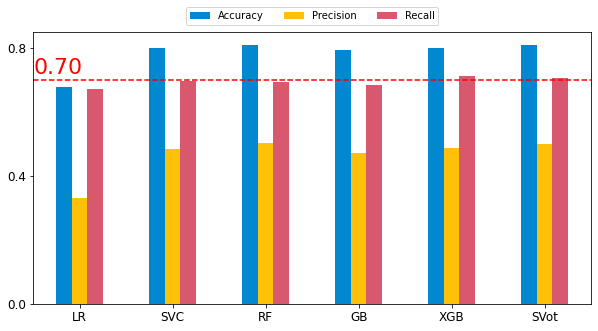

In [206]:
cc=['#0288D1', '#FFC107', '#D85870']
comparison_test_df.plot(kind='bar', figsize=(10, 5), fontsize=12, color=cc)

plt.legend(loc='upper center', ncol=len(comparison_test_df.columns), bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red')

> The performances on the test set for all models is fairly similar to the training set, indicating that there is no overfitting occurance here. Therefore, we can predict customer churn with a recall approximately equal to 72%. XGBoost did a relatively good job.

### Conclusion

Our notebook has come to an end! Our final report to the bank should be based on two main points:

* EDA can help us identify and understand the impact of factors that influence customer churn. In addition, feature importance analysis can quantify the importance of each feature in predicting the likelihood of churn. We found that the most significant feature is age (older customers more likely to churn), followed by the number of products (having more products increases a customer’s likelihood to churn, which can be understood better by discussion with an expert). The bank could use these insights to take necessary steps to achieve customer satisfaction and in turn, reduce their attrition.<br>
<br>
* We can build several machine learning models with recall approximately equal to 72%, meaning that they can successfully detect about 80% of customers who might churn. The predictive performance could be enhanced if there would be more data or features, so the bank could gather more data about their customers, for an even better predictive prowess. 

Thank you!
